In [74]:
# Imports
import numpy as np
import uproot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [75]:
# --- Plotting Functions (adapted) ---

# Re-define the plotting functions to accept PyTorch model outputs

def plot_confusion_matrix(y_true, y_pred, labels=["Background", "Signal"]):
    """
    Plot a normalized confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False, values_format=".2f")
    ax.set_title("Normalized Confusion Matrix")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

def plot_binned_background_shape(
    probs, # Pass probabilities directly now
    y_true, # Pass true labels
    mass_unscaled, # Pass the unscaled mass
    weight,
    bins=np.linspace(110, 160, 80),
    score_bins=[(0.00, 0.34), (0.34, 0.68), (0.68, 0.9), (0.9, 1.0)],
    colors=["blue", "orange", "green", "red"],
    higgs_mass=125
):
    """
    Plot binned dimuon mass distribution for background events,
    separated by classifier score bins, with exponential background fit.
    Now takes probabilities and unscaled mass directly.
    """

    # Ensure proper array types
    y_true = np.asarray(y_true)
    weight = np.asarray(weight)
    probs = np.asarray(probs)
    mass_unscaled = np.asarray(mass_unscaled)


    # Select background events
    mask_bkg = y_true == 0
    scores = probs[mask_bkg]
    masses = mass_unscaled[mask_bkg]
    weights_bkg = weight[mask_bkg]

    # Setup bins and labels
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    labels = [f"{low:.2f} ≤ Score < {high:.2f}" for (low, high) in score_bins]

    plt.figure(figsize=(9, 6))

    # Plot histograms by classifier score
    for (low, high), color, label in zip(score_bins, colors, labels):
        mask = (scores >= low) & (scores < high)
        hist, _ = np.histogram(masses[mask], bins=bins, weights=weights_bkg[mask], density=True)
        plt.step(bin_centers, hist, where="mid", color=color, label=label)

    # Full background shape and fit
    hist_all, _ = np.histogram(masses, bins=bins, weights=weights_bkg, density=True)
    try:
        # Filter out zeros from hist_all for fitting if necessary
        valid_indices = hist_all > 0
        popt, _ = curve_fit(exp_decay, bin_centers[valid_indices], hist_all[valid_indices], p0=(1, 0.1, 0))
        smoothed = exp_decay(bin_centers, *popt)
        plt.plot(bin_centers, smoothed, 'k--', label="Fitted Background Shape")
    except RuntimeError:
        print("⚠️ Background fit failed. Skipping fit curve.")
    except ValueError as e:
         print(f"⚠️ Background fit failed due to ValueError: {e}. Skipping fit curve.")


    # Higgs mass line
    plt.axvline(higgs_mass, color="gray", linestyle=":", label="Higgs Mass")

    # Final styling
    plt.xlabel(r"$M_{\mu\mu}$ [GeV]")
    plt.ylabel("Fraction of events")
    plt.title("Background Shape by Classifier Score")
    plt.legend(title="Score Bins")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

In [76]:
def load_data(file_path, columns, tree_name="tree_Hmumu"):
    """
    Load data from a ROOT file using uproot.
    """
    tree = uproot.open(file_path)[tree_name]
    df = tree.arrays(columns, library="pd")
    df_sampled = df.sample(frac=0.1)
    return df_sampled


def prepare_data(background_df, signal_df, mass_column="Muons_Minv_MuMu_Fsr", shuffle=True):
    """
    Combine background and signal datasets, shuffle, and split into features, labels, weights, and mass.
    """
    df = pd.concat([background_df, signal_df], ignore_index=True)

    if shuffle:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features, label, weight, and the specific mass variable for the adversary
    # Drop Binary_Target as it's the label, drop weight as it's not a feature for the NN
    # Drop the mass column from features X, as the adversary's goal is to prevent the classifier
    # from relying on it. The adversary will predict mass itself.
    # NOTE: Removing mass from X might make the classifier struggle initially.
    # An alternative is to keep mass in X but use adversarial training to make the *output*
    # independent of mass. For this example, let's remove it from X for clearer mass independence test.
    x = df.drop(["Binary_Target", "weight", mass_column], axis=1)
    y = df["Binary_Target"]
    mass = df[mass_column] # This will be the target for the adversary
    weight = df["weight"].to_numpy() # Keep weights separate if needed for evaluation/reweighting

    # Convert y and mass to numpy arrays if they aren't already
    y = y.to_numpy()
    mass = mass.to_numpy()


    return x, y, mass, weight


def split_and_scale(X, y, mass, weight, test_size=0.2):
    """
    Split the dataset and apply standard scaling to features and mass separately.
    """
    X_train, X_test, y_train, y_test, mass_train, mass_test, weight_train, weight_test = train_test_split(
        X, y, mass, weight, test_size=test_size, random_state=42, stratify=y
    )

    # Scale features (excluding mass)
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # Scale mass separately for the adversary's target
    mass_scaler = StandardScaler()
    mass_train_scaled = mass_scaler.fit_transform(mass_train.reshape(-1, 1)).flatten() # Reshape for scaler
    mass_test_scaled = mass_scaler.transform(mass_test.reshape(-1, 1)).flatten() # Reshape for scaler


    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # BCEWithLogitsLoss expects shape (N, 1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    mass_train_tensor = torch.tensor(mass_train_scaled, dtype=torch.float32).unsqueeze(1) # Target shape (N, 1)
    mass_test_tensor = torch.tensor(mass_test_scaled, dtype=torch.float32).unsqueeze(1)
    weight_train_tensor = torch.tensor(weight_train, dtype=torch.float32) # Keep weights separate
    weight_test_tensor = torch.tensor(weight_test, dtype=torch.float32)

    return (X_train_tensor, X_test_tensor,
            y_train_tensor, y_test_tensor,
            mass_train_tensor, mass_test_tensor,
            weight_train_tensor, weight_test_tensor,
            feature_scaler, mass_scaler,
            X_test.columns.tolist()) # Return feature names for plotting help


In [81]:
# --- PyTorch Model Definitions ---

class Classifier(nn.Module):
    def __init__(self, input_dim):
        super(Classifier, self).__init__()
        # Simple neural network classifier
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 16) # Output of this layer will feed into the adversary
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 1) # Final output layer for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        hidden_output = self.fc2(x) # This is the output before the last ReLU
        x = self.relu2(hidden_output)
        output = self.fc3(x) # Raw logits for BCEWithLogitsLoss
        return output, x # Return both for adversarial training

class Adversary(nn.Module):
    def __init__(self, input_dim): # Input dim is the size of the hidden_output from the classifier
        super(Adversary, self).__init__()
        # Simple neural network adversary to predict mass
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        # self.fc2 = nn.Linear(128, 128)
        # self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 1) # Predicts the scaled mass (continuous)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        # x = self.fc2(x)
        # x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        output = self.fc4(x) # Raw output for MSE loss
        return output

# --- Adversarial Training Function ---

def train_adversarial_model(classifier, adversary, train_loader,
                            classifier_optimizer, adversary_optimizer,
                            classifier_criterion, adversary_criterion,
                            lambda_adv, annealing_k, epochs):
    """
    Trains the classifier and adversary in an adversarial manner.
    """
    classifier.train()
    adversary.train()

    def get_lambda(epoch, total_epochs, k=10.0):
        p = epoch / total_epochs
        return lambda_adv * (2 / (1 + np.exp(-k * p)) - 1)

    for epoch in range(epochs):
        total_cls_loss = 0
        total_adv_loss = 0

        current_l_adv = get_lambda(epoch, epochs, k=annealing_k)

        print("current adversarial model weight (used in loss function): ", current_l_adv)

        for features, labels, mass_targets in train_loader:
            features, labels, mass_targets = features.to(device), labels.to(device), mass_targets.to(device)

            # --- Train Adversary ---
            adversary_optimizer.zero_grad()
            # Get the hidden output from the classifier, but detach it
            # so adversary training doesn't affect classifier gradients
            with torch.no_grad(): # Ensure no gradients are calculated for this forward pass in the classifier
                 _, hidden_output_detached = classifier(features)

            # --- Train Adversary Step (Corrected Data Flow) ---
            # Get the hidden output from the classifier, but detach it
            classifier_logits, classifier_hidden = classifier(features)
            hidden_output_detached = classifier_hidden.detach() # Detach hidden output
            adversary_mass_pred = adversary(hidden_output_detached)
            adv_loss = adversary_criterion(adversary_mass_pred, mass_targets)

            adv_loss.backward() # Backpropagate through adversary only
            adversary_optimizer.step() # Update adversary weights

            # --- Train Classifier ---
            classifier_optimizer.zero_grad()
            # Pass features through classifier again (or use the results from the first pass,
            # but ensure gradients are tracked this time)
            classifier_logits, classifier_hidden = classifier(features) # Gradients are tracked now
            cls_loss = classifier_criterion(classifier_logits, labels)

            # Pass the *non-detached* hidden output to the adversary for the classifier's loss calculation
            # The adversary's prediction from this will contribute negatively to the classifier's loss
            # This forces the classifier to change its hidden representation so the adversary does poorly
            adversary_mass_pred_for_cls = adversary(classifier_hidden)
            # print(adversary_mass_pred_for_cls)
            # The loss to maximize for the classifier is the adversary's loss.
            # So we subtract the adversary's loss (scaled by lambda) from the classifier's loss.
            # PyTorch minimizes loss, so minimizing (cls_loss - lambda * adv_loss)
            # is equivalent to minimizing cls_loss and maximizing lambda * adv_loss.
            Lc = cls_loss
            La = adversary_criterion(adversary_mass_pred_for_cls, mass_targets)

            classifier_total_loss = Lc - current_l_adv * La


            classifier_total_loss.backward() # Backpropagate through classifier (and adversary implicitly via graph)
            classifier_optimizer.step() # Update classifier weights

            total_cls_loss += cls_loss.item()
            total_adv_loss += adv_loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {total_cls_loss/len(train_loader):.4f}, Adversary Loss: {total_adv_loss/len(train_loader):.4f}")

    print("Training finished.")


# --- Evaluation Function (for PyTorch model) ---

def evaluate_pytorch_model(model, data_loader, device):
    """
    Evaluate the PyTorch classifier model.
    Returns predictions, probabilities, accuracy, and classification report.
    """
    model.eval() # Set model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad(): # Disable gradient calculation during evaluation
        for features, labels, _ in data_loader: # We don't need mass_targets here
            features, labels = features.to(device), labels.to(device)

            logits, _ = model(features) # Get classifier logits
            probs = torch.sigmoid(logits) # Convert logits to probabilities

            preds = (probs > 0.5).squeeze().cpu().numpy() # Convert probs to binary predictions
            probs_np = probs.squeeze().cpu().numpy() # Convert probs to numpy

            all_labels.extend(labels.squeeze().cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs_np)

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)

    return np.array(all_preds), np.array(all_probs), accuracy, report, np.array(all_labels)


['Jets_PT_Lead', 'Jets_PT_Sub', 'Jets_Phi_Lead', 'Jets_Phi_Sub', 'Jets_E_Lead', 'Jets_E_Sub', 'Jets_Eta_Lead', 'Jets_Eta_Sub', 'Muons_Phi_Lead', 'Muons_Phi_Sub', 'Muons_Eta_Lead', 'Muons_Eta_Sub']

Starting Adversarial Training...
current adversarial model weight (used in loss function):  0.0
Epoch 1/5, Classifier Loss: 0.6591, Adversary Loss: 0.9781
current adversarial model weight (used in loss function):  0.1993359892499118
Epoch 2/5, Classifier Loss: 0.6463, Adversary Loss: 0.9650
current adversarial model weight (used in loss function):  0.394750640449808
Epoch 3/5, Classifier Loss: 0.6463, Adversary Loss: 0.9691
current adversarial model weight (used in loss function):  0.5826252249031816
Epoch 4/5, Classifier Loss: 0.6494, Adversary Loss: 0.9817
current adversarial model weight (used in loss function):  0.75989792451045
Epoch 5/5, Classifier Loss: 0.6517, Adversary Loss: 0.9911
Training finished.

Evaluating Classifier...
Classifier Accuracy on Test Set: 0.6341
Classification Re

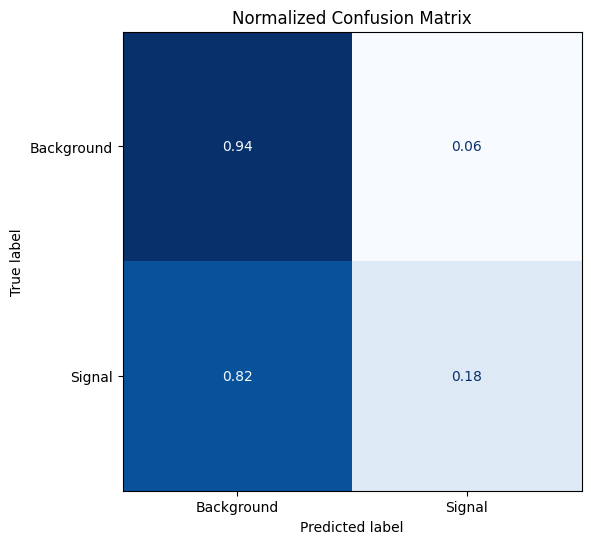

c:\Program Files\Python310\lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
c:\Program Files\Python310\lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\lode6\AppData\Local\Temp\ipykernel_27352\4145732981.py:87: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
C:\Users\lode6\AppData\Local\Temp\ipykernel_27352\4145732981.py:87: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


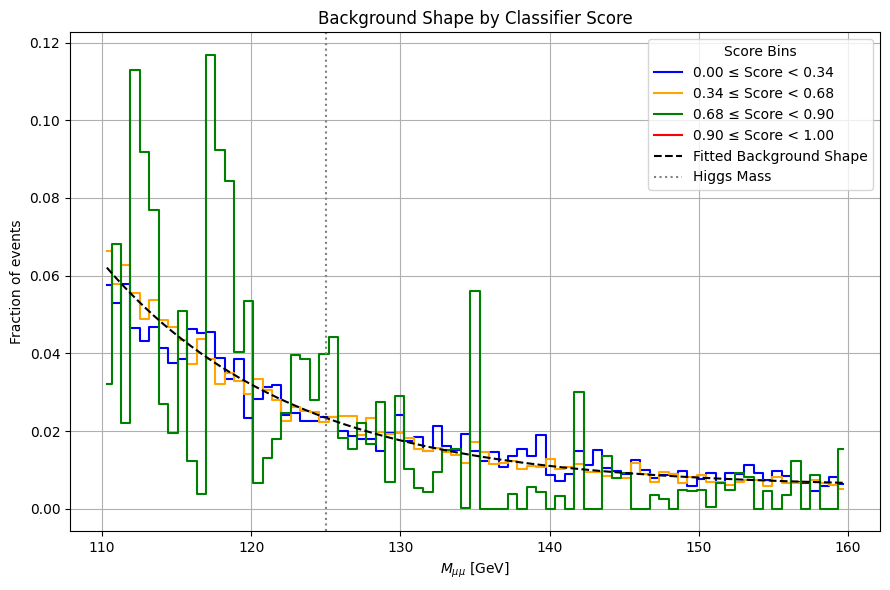

In [82]:
# --- Main Execution ---

# Columns used in the model training
COLUMNS = [
    'Jets_PT_Lead', 'Jets_PT_Sub',
    'Jets_Phi_Lead', 'Jets_Phi_Sub',
    'Jets_E_Lead', 'Jets_E_Sub',
    'Jets_Eta_Lead', 'Jets_Eta_Sub',
    # 'Muons_PT_Lead', 'Muons_PT_Sub',
    'Muons_Phi_Lead', 'Muons_Phi_Sub',
    'Muons_Eta_Lead', 'Muons_Eta_Sub',
    'Muons_Minv_MuMu_Fsr', # Keep this here to load it
    'weight',
    'Binary_Target'
]

# Load the data
background_df = load_data("./../Fairness data/Background.root", COLUMNS)
signal_df = load_data("./../Fairness data/Signal.root", COLUMNS)

# Prepare the data - now also extracts mass
x_val, y_val, mass_val, weight_val = prepare_data(background_df, signal_df, mass_column='Muons_Minv_MuMu_Fsr')

# Split and scale - now also handles mass scaling and returns tensors
(X_train_tensor, X_test_tensor,
 y_train_tensor, y_test_tensor,
 mass_train_tensor, mass_test_tensor,
 weight_train_tensor, weight_test_tensor,
 feature_scaler, mass_scaler,
 feature_names) = split_and_scale(x_val, y_val, mass_val, weight_val)


# --- PyTorch Setup ---

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, mass_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, mass_test_tensor) # Include mass for plotting later

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# Don't shuffle test loader to keep order consistent for plotting/evaluation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# Instantiate models
input_dim = X_train_tensor.shape[1]
classifier = Classifier(input_dim).to(device)
# The adversary's input dimension is the output dimension of the classifier's last hidden layer
adversary_input_dim = classifier.fc2.out_features # Get the output size of the fc2 layer
adversary = Adversary(adversary_input_dim).to(device)

# Loss functions
classifier_criterion = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss is numerically stable for sigmoid output
adversary_criterion = nn.MSELoss() # MSE for predicting continuous scaled mass

# Optimizers
CLASSIFIER_LR = 0.002
ADVERSARY_LR = 0.005 # Can use different learning rates
classifier_optimizer = optim.Adam(classifier.parameters(), lr=CLASSIFIER_LR)
adversary_optimizer = optim.Adam(adversary.parameters(), lr=ADVERSARY_LR)

# Adversarial training hyperparameters
LAMBDA_ADV = 2 # Weight for the adversarial loss (tune this!)
ANNEALING_K = 1.0 
EPOCHS = 5 # Number of training epochs (tune this!)

print(feature_names)

# --- Train the Adversarial Model ---
print("\nStarting Adversarial Training...")
train_adversarial_model(
    classifier=classifier,
    adversary=adversary,
    train_loader=train_loader,
    classifier_optimizer=classifier_optimizer,
    adversary_optimizer=adversary_optimizer,
    classifier_criterion=classifier_criterion,
    adversary_criterion=adversary_criterion,
    lambda_adv=LAMBDA_ADV, annealing_k=ANNEALING_K,
    epochs=EPOCHS
)


# --- Evaluate the Classifier ---
print("\nEvaluating Classifier...")
test_preds, test_probs, test_accuracy, test_report, test_labels = evaluate_pytorch_model(classifier, test_loader, device)

print(f"Classifier Accuracy on Test Set: {test_accuracy:.4f}")
print("Classification Report on Test Set:")
print(test_report)

# --- Plotting ---

# Plot Confusion Matrix
plot_confusion_matrix(test_labels, test_preds)


# Get the original unscaled mass for plotting the background shape
# The mass_test_tensor contains the *scaled* mass.
# We need the unscaled mass from the original mass_val array,
# filtered to match the split order of the test set.
# The split_and_scale function returns the numpy arrays used *before* converting to tensors,
# so we can access the unscaled mass test set directly from the return values of split_and_scale.
# Let's add the unscaled mass_test numpy array to the return values of split_and_scale.

# Rerun split_and_scale to get unscaled mass_test
(X_train_tensor, X_test_tensor,
 y_train_tensor, y_test_tensor,
 mass_train_tensor, mass_test_tensor,
 weight_train_tensor, weight_test_tensor,
 feature_scaler, mass_scaler,
 feature_names) = split_and_scale(x_val, y_val, mass_val, weight_val) # Need the unscaled mass_test here


# plot_binned_background_shape expects the unscaled mass_test numpy array
plot_binned_background_shape(
    probs=test_probs,
    y_true=test_labels,
    mass_unscaled=mass_scaler.inverse_transform(mass_test_tensor.cpu().numpy().reshape(-1, 1)).flatten(), # Need unscaled mass
    weight=weight_test_tensor.cpu().numpy() # Need original weights
)

plt.show()

In [79]:
MODEL_SAVE_PATH = "adversarial_model/bigger_model_bad_bias.pth"
# Uncomment to save trained classifier
print(f"\nSaving classifier model to {MODEL_SAVE_PATH}...")
torch.save(classifier.state_dict(), MODEL_SAVE_PATH)
print("Model saved.")


Saving classifier model to adversarial_model/bigger_model_bad_bias.pth...
Model saved.



Example: Loading model from adversarial_model/bigger_model_bad_bias.pth...

Evaluating Classifier...
Classifier Accuracy on Test Set: 0.6279
Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       0.63      0.92      0.75     48001
         1.0       0.61      0.19      0.29     32066

    accuracy                           0.63     80067
   macro avg       0.62      0.56      0.52     80067
weighted avg       0.62      0.63      0.56     80067

Model loaded successfully.


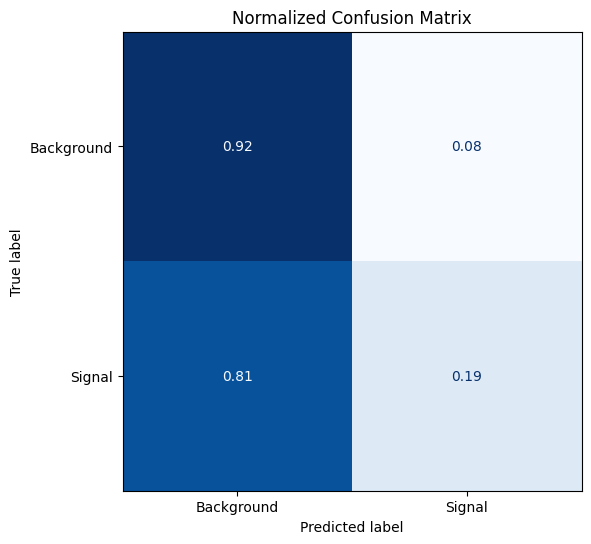

c:\Program Files\Python310\lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
c:\Program Files\Python310\lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
C:\Users\lode6\AppData\Local\Temp\ipykernel_27352\4145732981.py:87: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
C:\Users\lode6\AppData\Local\Temp\ipykernel_27352\4145732981.py:87: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


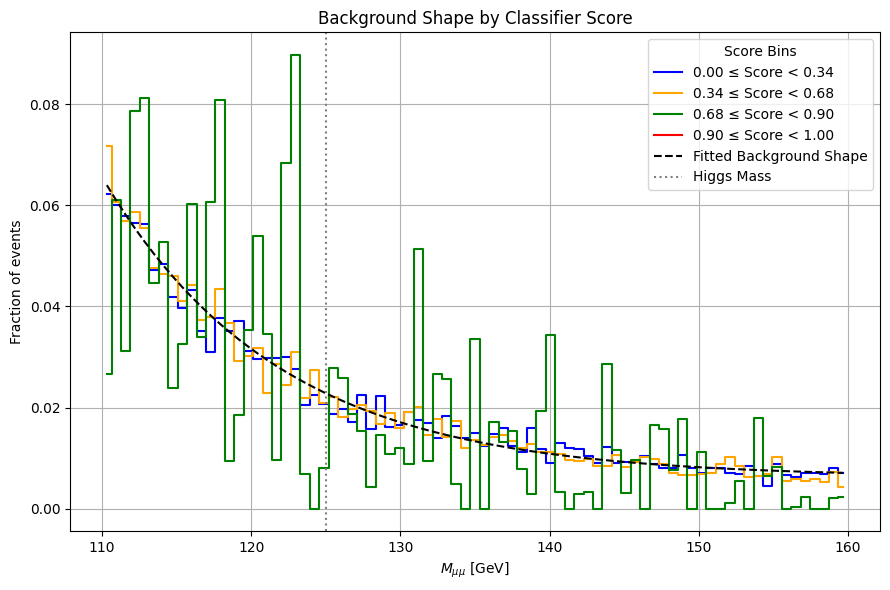

In [80]:
# --- Example of Loading the Model (for future inference) ---
print(f"\nExample: Loading model from {MODEL_SAVE_PATH}...")

# You need to instantiate the model class first
loaded_classifier = Classifier(input_dim).to(device)

# Load the state dictionary
loaded_classifier.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Set the model to evaluation mode (important for inference)
loaded_classifier.eval()

print("\nEvaluating Classifier...")
test_preds, test_probs, test_accuracy, test_report, test_labels = evaluate_pytorch_model(loaded_classifier, test_loader, device)

print(f"Classifier Accuracy on Test Set: {test_accuracy:.4f}")
print("Classification Report on Test Set:")
print(test_report)

print("Model loaded successfully.")

plot_confusion_matrix(test_labels, test_preds)


# Get the original unscaled mass for plotting the background shape
# The mass_test_tensor contains the *scaled* mass.
# We need the unscaled mass from the original mass_val array,
# filtered to match the split order of the test set.
# The split_and_scale function returns the numpy arrays used *before* converting to tensors,
# so we can access the unscaled mass test set directly from the return values of split_and_scale.
# Let's add the unscaled mass_test numpy array to the return values of split_and_scale.

# Rerun split_and_scale to get unscaled mass_test
(X_train_tensor, X_test_tensor,
 y_train_tensor, y_test_tensor,
 mass_train_tensor, mass_test_tensor,
 weight_train_tensor, weight_test_tensor,
 feature_scaler, mass_scaler,
 feature_names) = split_and_scale(x_val, y_val, mass_val, weight_val) # Need the unscaled mass_test here

# plot_binned_background_shape expects the unscaled mass_test numpy array
plot_binned_background_shape(
    probs=test_probs,
    y_true=test_labels,
    mass_unscaled=mass_scaler.inverse_transform(mass_test_tensor.cpu().numpy().reshape(-1, 1)).flatten(), # Need unscaled mass
    weight=weight_test_tensor.cpu().numpy() # Need original weights
)

plt.show()